In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [26]:
df = pd.read_excel('data/laporan_iklim_harian.xlsx')
df.head()

,NamaStasiun,WMOID,Tanggal,SuhuMinimum(°C),SuhuMaksimum(°C),SuhuRata-rata(°C),KelembabanRata-rata(%),CurahHujan(mm),LamaPenyinaran(jam),Kecepata AnginRata-rata(knot),ArahAnginTerbanyak(deg),KecepatanAnginTerbesar(knot),ArahAnginSaatKecepatanMaksimum(deg)
0,Stasiun Meteorologi Sultan Mahmud Badaruddin II,96221,2014-01-01,24.2,28.4,26.3,89,1.3,0.6,8,NW,8,315
1,Stasiun Meteorologi Sultan Mahmud Badaruddin II,96221,2014-01-02,24.1,30.4,26.6,88,0.0,1.8,8,N,8,315
2,Stasiun Meteorologi Sultan Mahmud Badaruddin II,96221,2014-01-03,23.3,30.6,26.5,88,1.2,1.0,7,NW,7,315
3,Stasiun Meteorologi Sultan Mahmud Badaruddin II,96221,2014-01-04,23.0,31.4,26.9,85,1.8,0.0,8,NW,8,270
4,Stasiun Meteorologi Sultan Mahmud Badaruddin II,96221,2014-01-05,23.0,31.0,26.2,84,3.1,1.2,8,NW,8,315


In [27]:
df.drop(['Tanggal', 'NamaStasiun ', 'WMOID', 'SuhuMinimum(°C)', 'SuhuMaksimum(°C)', 'ArahAnginSaatKecepatanMaksimum(deg)'], axis=1, inplace=True)

In [28]:
df.head()

,SuhuRata-rata(°C),KelembabanRata-rata(%),CurahHujan(mm),LamaPenyinaran(jam),Kecepata AnginRata-rata(knot),ArahAnginTerbanyak(deg),KecepatanAnginTerbesar(knot)
0,26.3,89,1.3,0.6,8,NW,8
1,26.6,88,0.0,1.8,8,N,8
2,26.5,88,1.2,1.0,7,NW,7
3,26.9,85,1.8,0.0,8,NW,8
4,26.2,84,3.1,1.2,8,NW,8


In [29]:
df.dtypes

SuhuRata-rata(°C)                float64
KelembabanRata-rata(%)             int64
CurahHujan(mm)                   float64
LamaPenyinaran(jam)              float64
Kecepata AnginRata-rata(knot)      int64
ArahAnginTerbanyak(deg)           object
KecepatanAnginTerbesar(knot)       int64
dtype: object

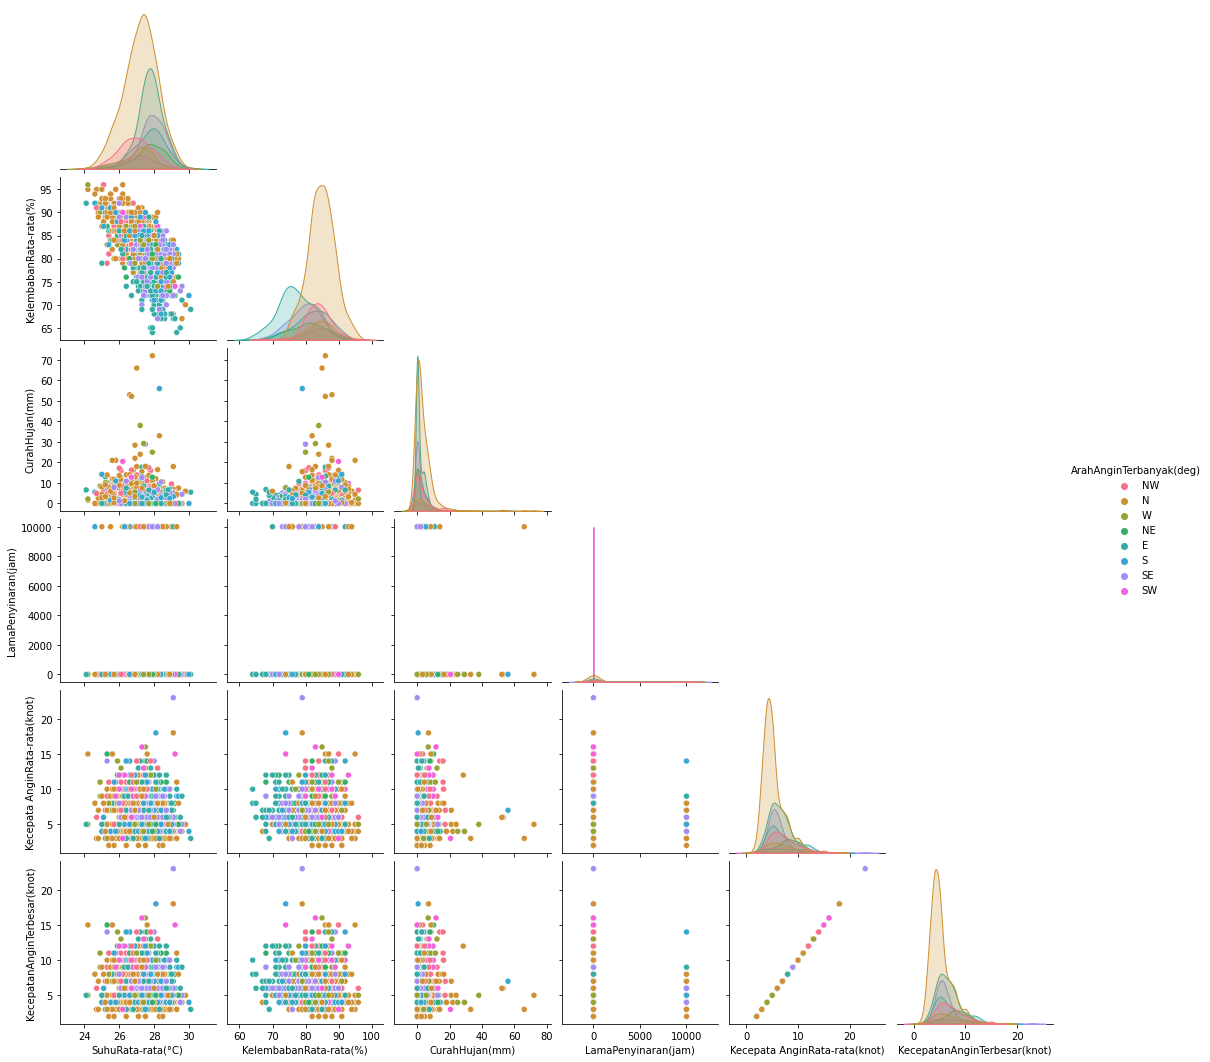

In [30]:
sns.pairplot(data= df, hue='ArahAnginTerbanyak(deg)', palette='husl', corner=True)

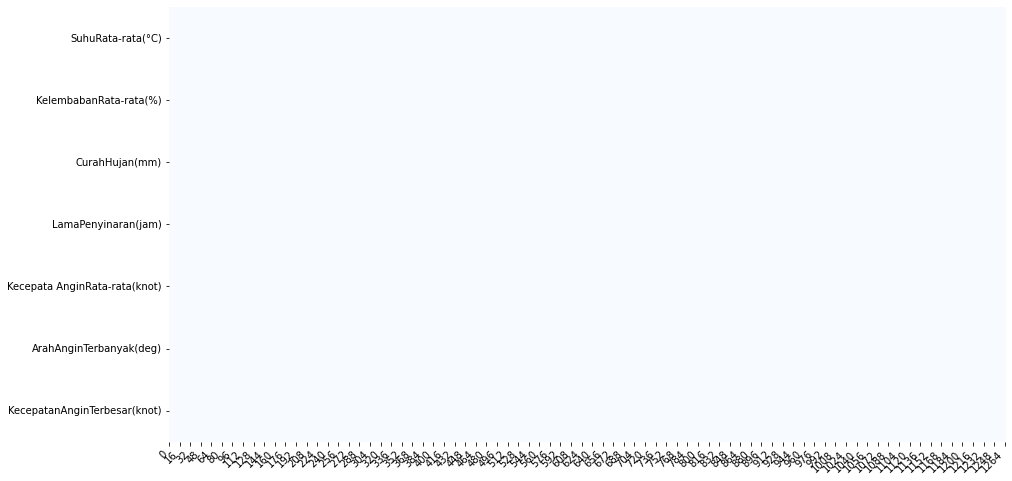

In [31]:
plot_missing_value(df)

In [32]:
df.columns

Index(['SuhuRata-rata(°C)', 'KelembabanRata-rata(%)', 'CurahHujan(mm)',
       'LamaPenyinaran(jam)', 'Kecepata AnginRata-rata(knot)',
       'ArahAnginTerbanyak(deg)', 'KecepatanAnginTerbesar(knot)'],
      dtype='object')

In [33]:
# numeric = ['SuhuRata-rata(°C)',
#     'KelembabanRata-rata(%)', 'LamaPenyinaran(jam)',
#     'Kecepata AnginRata-rata(knot)',
#     'KecepatanAnginTerbesar(knot)']
# from scipy import stats
# df = (df[(np.abs(stats.zscore(df[numeric])) < 2).all(axis=1)])
# df.shape

In [34]:
X = df.drop(columns=["CurahHujan(mm)"])
y = df["CurahHujan(mm)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1012, 6), (254, 6), (1012,), (254,))

In [35]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['SuhuRata-rata(°C)',
    'KelembabanRata-rata(%)', 'LamaPenyinaran(jam)',
    'Kecepata AnginRata-rata(knot)',
    'KecepatanAnginTerbesar(knot)']),
    ('categoric', cat_pipe(encoder='onehot'), ['ArahAnginTerbanyak(deg)']),
])

from xgboost import XGBRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.28714749658136995, 'algo__gamma': 4, 'algo__learning_rate': 0.023426581058204037, 'algo__max_depth': 2, 'algo__n_estimators': 189, 'algo__reg_alpha': 0.06295301484516136, 'algo__reg_lambda': 0.038071583792493945, 'algo__subsample': 0.7633294328968971}
0.10219578249875705 0.041527625745801454 0.015810261342054988


C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


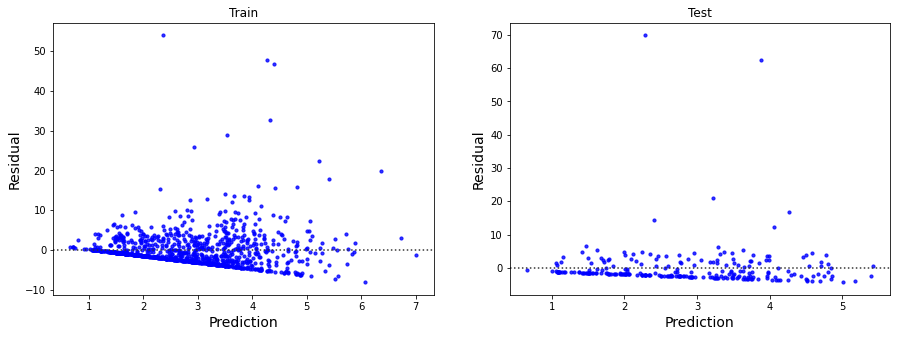

In [36]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual
plot_residual(X_train, y_train, X_test, y_test, model)

In [37]:
df["CurahHujan(mm)"].value_counts()

0.0     573
1.0      23
4.0      18
1.8      17
0.2      16
       ... 
66.0      1
7.7       1
72.0      1
13.0      1
29.2      1
Name: CurahHujan(mm), Length: 149, dtype: int64

In [38]:
df["curahHujan"] = df["CurahHujan(mm)"].apply(lambda x: 1 if x > 0 else 0)

In [39]:
df["curahHujan"].value_counts()

1    693
0    573
Name: curahHujan, dtype: int64

In [40]:
df.drop(columns=["CurahHujan(mm)"], inplace=True)

In [41]:
X = df.drop(columns=["curahHujan"])
y = df["curahHujan"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1012, 6), (254, 6), (1012,), (254,))

In [42]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax"), ['SuhuRata-rata(°C)',
    'KelembabanRata-rata(%)', 'LamaPenyinaran(jam)',
    'Kecepata AnginRata-rata(knot)',
    'KecepatanAnginTerbesar(knot)']),
    ('categoric', cat_pipe(encoder='onehot'), ['ArahAnginTerbanyak(deg)']),
])

from xgboost import XGBClassifier
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[12:46:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'algo__colsample_bytree': 0.7950202923669918, 'algo__gamma': 8, 'algo__learning_rate': 0.010257563974185648, 'algo__max_depth': 3, 'algo__n_estimators': 180, 'algo__reg_alpha': 0.7004349545230065, 'algo__reg_lambda': 1.4477786306928684, 'algo__subsample': 0.6029799873905057}
0.6818181818181818 0.6738831434106486 0.65748031496063


C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


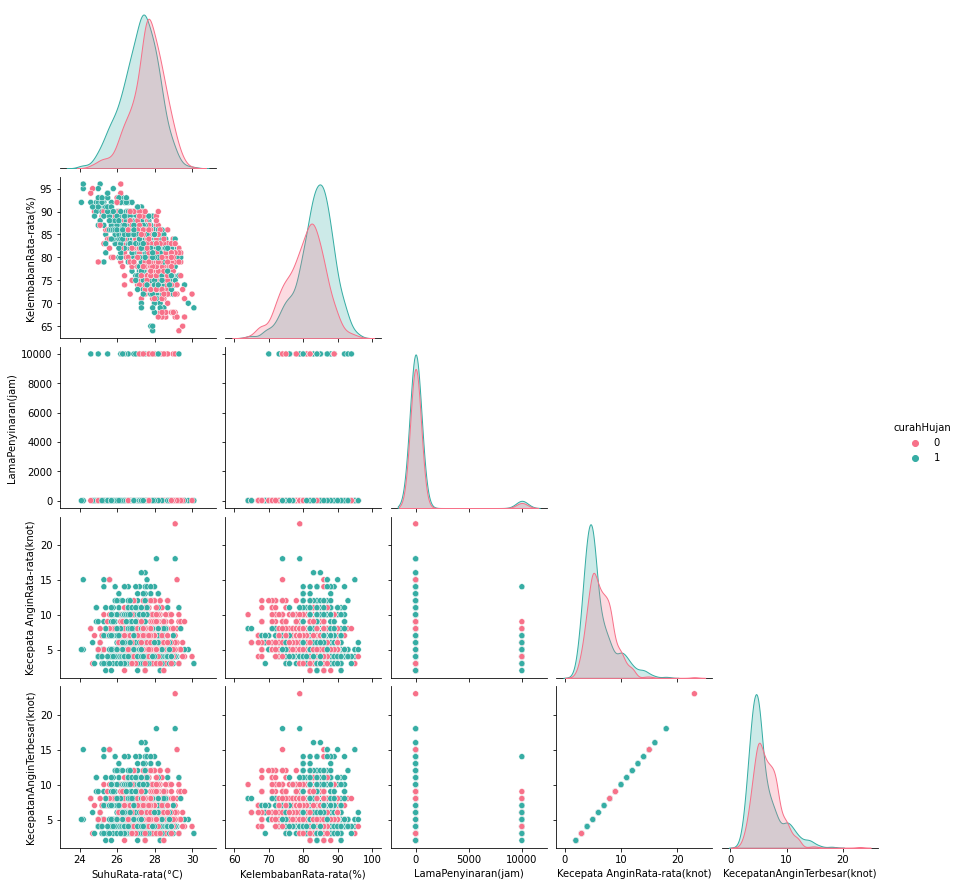

In [43]:
sns.pairplot(data= df, hue='curahHujan', palette='husl', corner=True)

In [44]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax"), ['SuhuRata-rata(°C)',
    'KelembabanRata-rata(%)', 'LamaPenyinaran(jam)',
    'Kecepata AnginRata-rata(knot)',
    'KecepatanAnginTerbesar(knot)']),
    ('categoric', cat_pipe(encoder='onehot'), ['ArahAnginTerbanyak(deg)']),
])

from sklearn.svm import SVC
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 0.1, 'algo__gamma': 10.0}
0.6699604743083004 0.6600530261794814 0.6141732283464567


C:\Users\Toko Ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [45]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax"), ['SuhuRata-rata(°C)',
    'KelembabanRata-rata(%)', 'LamaPenyinaran(jam)',
    'Kecepata AnginRata-rata(knot)',
    'KecepatanAnginTerbesar(knot)']),
    ('categoric', cat_pipe(encoder='onehot'), ['ArahAnginTerbanyak(deg)']),
])

from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 30, 'algo__max_features': 0.5133240027692805, 'algo__min_samples_leaf': 4, 'algo__n_estimators': 123}
0.8606719367588933 0.6600910692442307 0.6417322834645669
